##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples.

This notebook assumes you are familiar with Pix2Pix, which you can learn about in the [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix). The code for CycleGAN is similar, the main difference is an additional loss function, and the use of unpaired training data.

CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain.

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All you need is the source and the target dataset (which is simply a directory of images).

![Output Image 1](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_1.png?raw=1)
![Output Image 2](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_2.png?raw=1)

## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ktvzs28v
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-ktvzs28v
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=0d74b6a97270e8a901bdf2e5bf568ae0b1b9a8c836c3bf9a9606dcfc8bfacdff
  Stored in directory: /tmp/pip-ephem-wheel-cache-1l5t8a0c/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
# Instalar dependências necessárias
!pip install apache_beam
!pip install tensorflow-datasets
!pip install tensorflow-addons


import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE


import shutil
from PIL import Image, ImageOps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.6/255.6 kB 22.6 MB/s eta 0:00:00

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/catalog/cycle_gan).

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e., left to right.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os


def download_dataset_images(zip_path, extract_to_path = './MBAIA_DATASETS/TCC/fashion_dataset_256'):
    # Verificando se o caminho de destino existe, se não, cria o diretório
    if not os.path.exists(extract_to_path):
       os.makedirs(extract_to_path)

    # Abrindo o arquivo ZIP em modo de leitura
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extraindo todos os arquivos no diretório especificado
        zip_ref.extractall(extract_to_path)


## Busca o dataset com a base de imagens com 256px
download_dataset_images('./drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256_cycle_100.zip')

print(f'Arquivos extraídos!')

Arquivos extraídos!


Redimensiona as imagens para 256px e organiza o dataset em duas pastas para treinar o modelo e para testar

**Escreva o Script de Definição do Dataset**

In [ ]:
%%writefile ./MBAIA_DATASETS/TCC/fashion_dataset_256/fashion_dataset.py
import tensorflow_datasets as tfds
import tensorflow as tf
import os


class MyDataset(tfds.core.GeneratorBasedBuilder):
    VERSION = tfds.core.Version('0.1.0')

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description="Dataset com imagens estampadas e roupas superiores.",
            features=tfds.features.FeaturesDict({
                "image": tfds.features.Image(),
                "label": tfds.features.ClassLabel(names=["upper_part_fashion", "printed_clothes"]),
            }),
            supervised_keys=("image", "label"),
            homepage='https://cursosextensao.usp.br/',
            citation=r"""@article{printedclothesdataset2024, title={Printed Clothes Dataset},}""",
        )

    def _split_generators(self, dl_manager):
        path_to_images = os.path.abspath('./MBAIA_DATASETS/TCC/fashion_dataset_256/')
        return [
            tfds.core.SplitGenerator(
                name=tfds.Split.TRAIN,
                gen_kwargs={"images_dir_path": os.path.join(path_to_images, "train")},
            ),
            tfds.core.SplitGenerator(
                name=tfds.Split.TEST,
                gen_kwargs={"images_dir_path": os.path.join(path_to_images, "test")},
            ),
        ]

    def _generate_examples(self, images_dir_path):
        for category in ['upper_part_fashion', 'printed_clothes']:
            category_path = os.path.join(images_dir_path, category)
            if tf.io.gfile.exists(category_path):
                for image_file in tf.io.gfile.listdir(category_path):
                    if image_file.endswith(('.jpg', '.jpeg', '.png')):  # Garantir que são arquivos de imagem
                        image_path = os.path.join(category_path, image_file)
                        yield image_file, {
                            "image": image_path,
                            "label": category,
                        }
            else:
                print("Category path does not exist:", category_path)

Writing ./MBAIA_DATASETS/TCC/fashion_dataset_256/fashion_dataset.py


In [ ]:
!tfds build ./MBAIA_DATASETS/TCC/fashion_dataset_256/fashion_dataset.py

INFO[build.py]: Loading dataset ./MBAIA_DATASETS/TCC/fashion_dataset_256/fashion_dataset.py from path: /content/MBAIA_DATASETS/TCC/fashion_dataset_256/fashion_dataset.py
2024-08-16 23:03:24.342048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 23:03:24.363491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 23:03:24.370269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 23:03:25.969496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-16 23:03:27.178302: W external/local_tsl/tsl/platform/cloud/goo

In [ ]:
# Carregar os dados de treinamento e teste do seu dataset personalizado
ds, info = tfds.load(
    'my_dataset',  # Nome do seu dataset conforme definido na classe TFDS
    split=['train', 'test'],  # Especificar os splits que você deseja carregar
    as_supervised=True,  # Carregar os dados no formato (input, label)
    with_info=True  # Carregar as informações do dataset também
)

# Extrair train e test dos splits carregados
ds_train, ds_test = ds[0], ds[1]

# Labels podem ser acessadas do objeto info, supondo 0 para 'upper_part_fashion' e 1 para 'printed_clothes'
label_upper_part_fashion = 0
label_printed_clothes = 1

# Filtrar os dados de treinamento e teste
train_upper_part_fashion = ds_train.filter(lambda img, label: label == label_upper_part_fashion)
train_printed_clothes = ds_train.filter(lambda img, label: label == label_printed_clothes)

test_upper_part_fashion = ds_test.filter(lambda img, label: label == label_upper_part_fashion)
test_printed_clothes = ds_test.filter(lambda img, label: label == label_printed_clothes)

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image


# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image


def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image


def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_upper_part_fashion = train_upper_part_fashion.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_printed_clothes = train_printed_clothes.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_upper_part_fashion = test_upper_part_fashion.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_printed_clothes = test_printed_clothes.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_upper_part_fashion = next(iter(train_upper_part_fashion))
sample_printed_clothes = next(iter(train_printed_clothes))

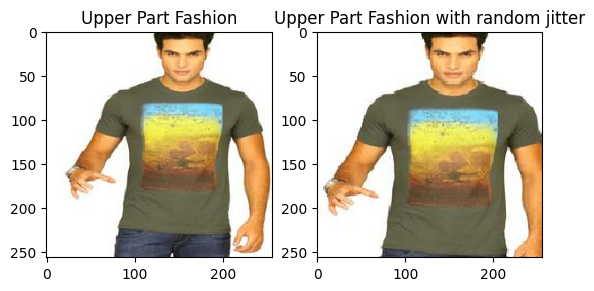

In [ ]:
plt.subplot(121)
plt.title('Upper Part Fashion')
plt.imshow(sample_upper_part_fashion[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Upper Part Fashion with random jitter')
plt.imshow(random_jitter(sample_upper_part_fashion[0]) * 0.5 + 0.5)

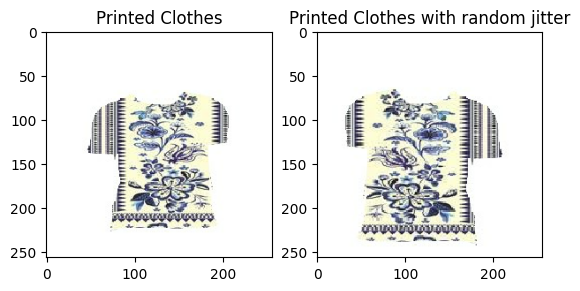

In [ ]:
plt.subplot(121)
plt.title('Printed Clothes')
plt.imshow(sample_printed_clothes[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Printed Clothes with random jitter')
plt.imshow(random_jitter(sample_printed_clothes[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

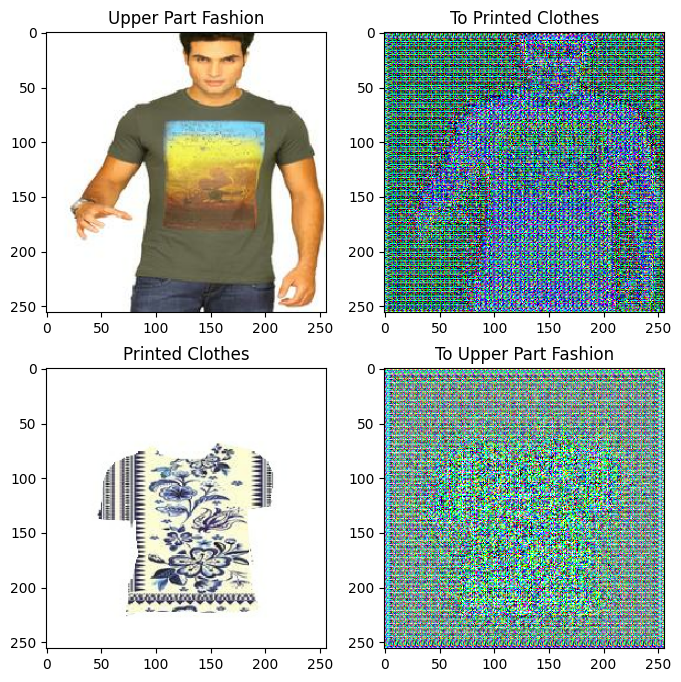

In [ ]:
to_printed_clothes = generator_g(sample_upper_part_fashion)
to_upper_part_fashion = generator_f(sample_printed_clothes)
plt.figure(figsize=(8, 8))
contrast = 10

imgs = [sample_upper_part_fashion, to_printed_clothes, sample_printed_clothes, to_upper_part_fashion]
title = ['Upper Part Fashion', 'To Printed Clothes', 'Printed Clothes', 'To Upper Part Fashion']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

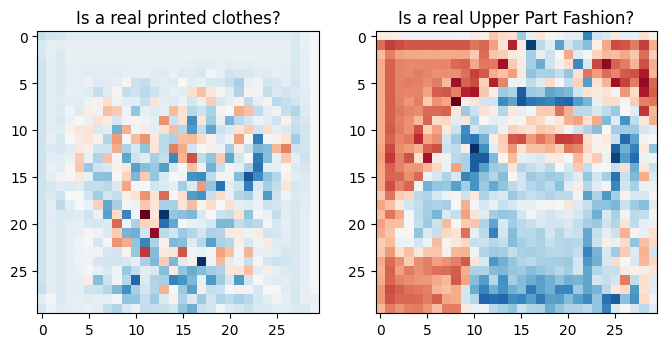

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real printed clothes?')
plt.imshow(discriminator_y(sample_printed_clothes)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Upper Part Fashion?')
plt.imshow(discriminator_x(sample_upper_part_fashion)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss,

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [ ]:
checkpoint_path = "./drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256/cyclegan_checkpoints_200_epochs_A100"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

Note: This example model is trained for fewer epochs (10) than the paper (200) to keep training time reasonable for this tutorial. The generated images will have much lower quality.

In [ ]:
EPOCHS = 200

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

  return prediction[0]

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

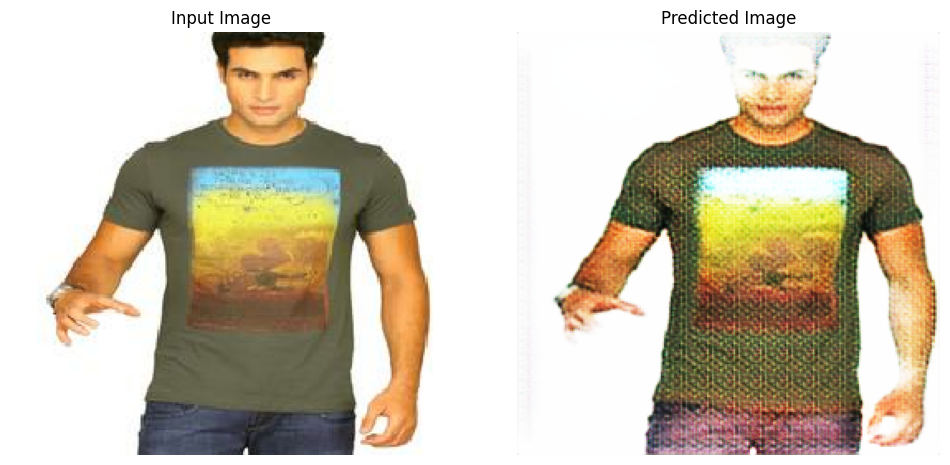

Time taken for epoch 19 is 6.374325752258301 sec

.......

KeyboardInterrupt: 

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_upper_part_fashion, train_printed_clothes)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_upper_part_fashion) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_upper_part_fashion)

  if (epoch + 1) % 250 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

inception_model = hub.KerasLayer("https://tfhub.dev/tensorflow/tfgan/eval/inception/1", trainable=False)

def calculate_inception_score(images, inception_model):
    images = tf.image.resize(images, [299, 299])  # Redimensionar imagens
    images = tf.keras.applications.inception_v3.preprocess_input(images)  # Pré-processamento

    # Obter previsões de logits do modelo Inception
    #logits = inception_model(images)
    logits = inception_model(images)['logits']

    # Calcular probabilidades softmax
    p_yx = tf.nn.softmax(logits)

    # Calcular as marginais
    p_y = tf.reduce_mean(p_yx, axis=0)

    # Calcular o Inception Score
    kl_divergence = p_yx * (tf.math.log(p_yx) - tf.math.log(p_y))
    score = tf.reduce_mean(tf.reduce_sum(kl_divergence, axis=1))
    return tf.exp(score)

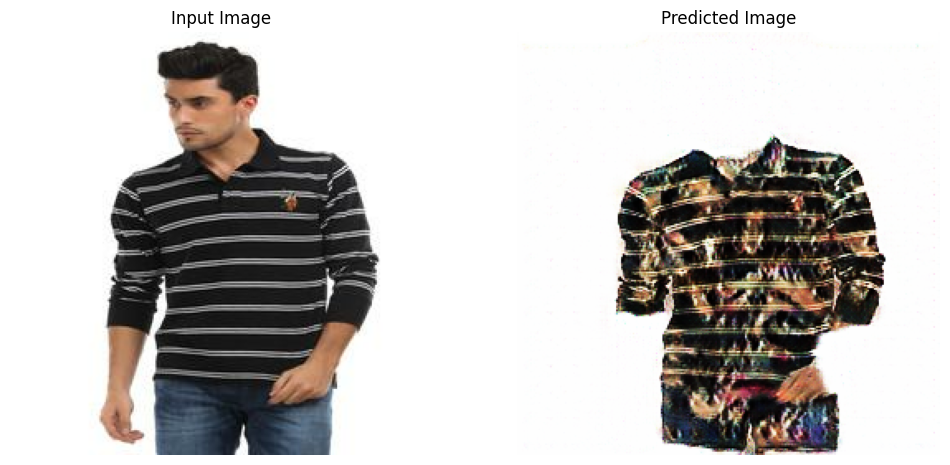

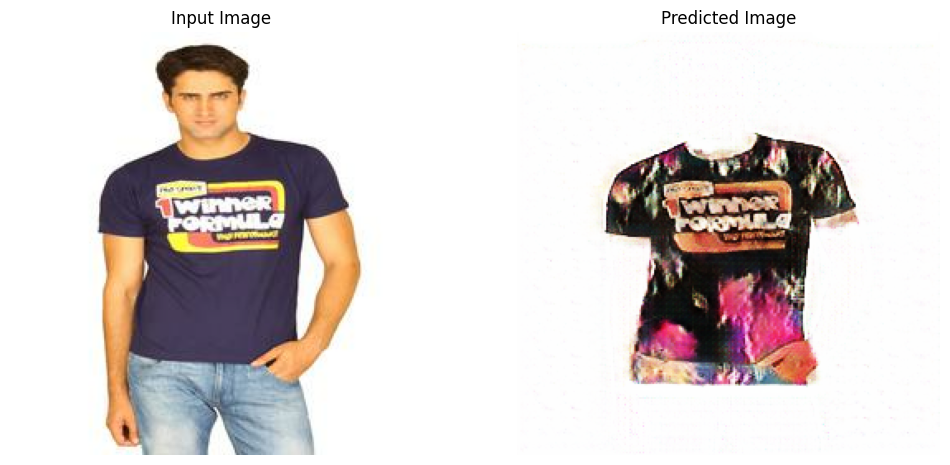

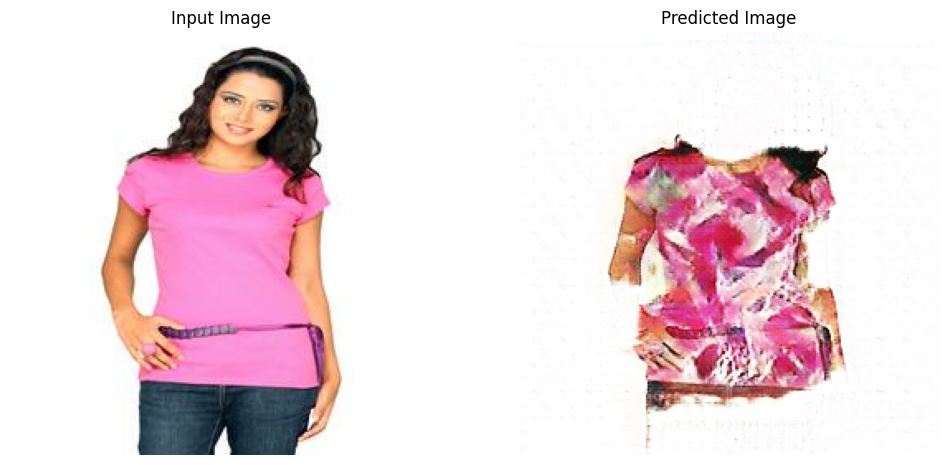

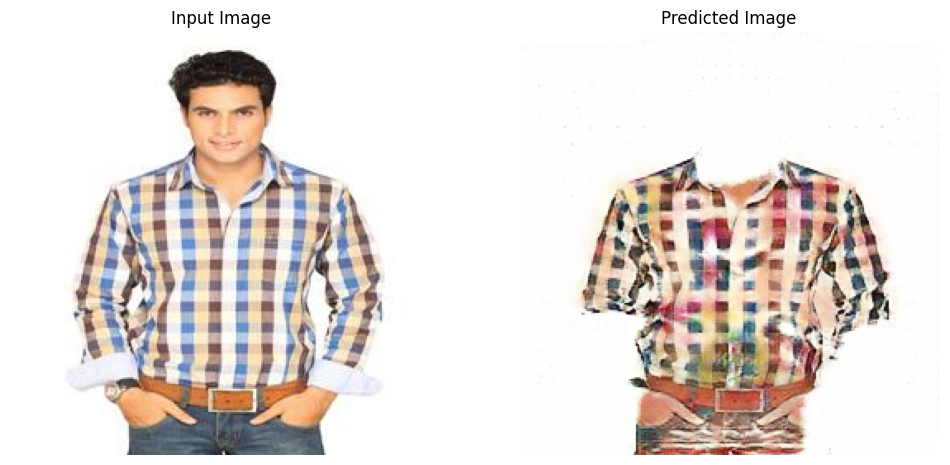

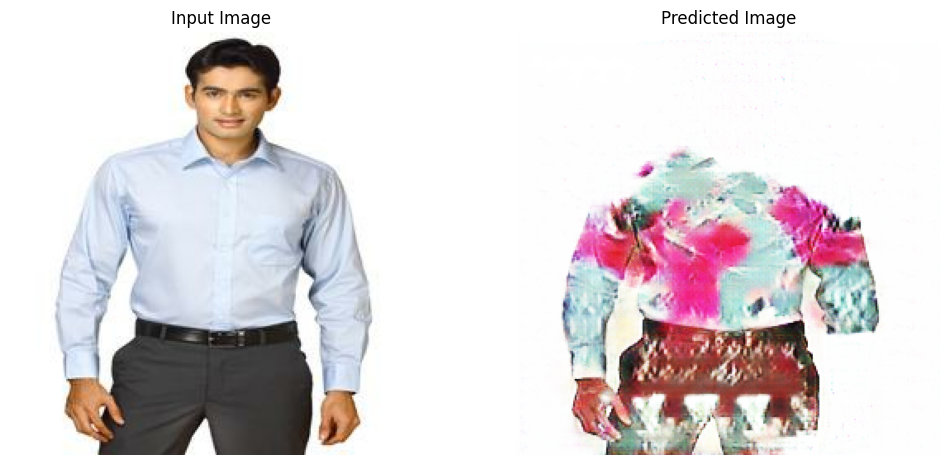

Inception Score: 1.0927993059158325


In [ ]:
# Run the trained model on the test dataset
# Lista para armazenar as imagens geradas
generated_images = []

# Loop para gerar imagens e coletá-las para cálculo do IS
for inp in test_upper_part_fashion.take(5):
    generated_image = generate_images(generator_g, inp)
    # Check if generate_images returns a valid tensor before appending
    if generated_image is not None:
        generated_images.append(generated_image)

# Converter a lista de imagens geradas para um tensor
# Verificar se a lista de imagens geradas não está vazia
if generated_images:
    # Converter a lista de imagens geradas para um tensor
    generated_images = tf.stack(generated_images)

    # Calcular o Inception Score para as imagens geradas
    is_score = calculate_inception_score(generated_images, inception_model)
    print(f"Inception Score: {is_score}")
else:
    print("Nenhuma imagem válida foi gerada.")

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan).

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.

In [ ]:
## Move arquivos do treinamento para drive

import shutil
import os

def move_folder_to_drive(source_folder, destination_folder):

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    shutil.move(source_folder, destination_folder)

# Exemplo de uso:
source_folder = './MBAIA_DATASETS/TCC/fashion_dataset_256/checkpoints'
destination_folder = './drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256/checkpoints_100_epochs'
move_folder_to_drive(source_folder, destination_folder)


Error: Destination path './drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256/checkpoints_100_epochs/checkpoints' already exists